In [8]:
#!/usr/bin/env python3
"""
GLANCE vs MapBiomas Forest Comparison on Google Earth Engine
Exports confusion metrics and forest rasters to Google Drive.

Requires: earthengine-api (and optional geemap for map previews).
Authenticate once with ee.Authenticate(), then run.
"""

import ee
from datetime import datetime

# ---------- User configuration ----------
YEARS = [2018]
MB_ASSET = "projects/ee-zcs/assets/AMZ2018M"
GLANCE_PREFIX = "projects/GLANCE/DATASETS/V001"
     # e.g. GLANCE_2016
AOI_ASSET = "projects/ee-zcs/assets/AMZ2018M"         # FeatureCollection
FOREST_MB = [1, 2, 9]                                 # MapBiomas forest classes
FOREST_GLANCE = [5]                                   # GLANCE forest classes
NODATA = 255
EXPORT_FOLDER = "forest_confusion"                    # Google Drive folder
SCALE = 30
TILE_SCALE = 4                                        # increase if region large
# ---------------------------------------

def init_ee():
    try:
        ee.Initialize()
    except Exception:
        ee.Authenticate()
        ee.Initialize()

def get_aoi():
    return ee.Image(AOI_ASSET).geometry()

def reclass_to_binary(image, forest_classes):
    """
    Reclassifies an image to binary: 1 for forest classes, 0 otherwise.
    
    Args:
        image (ee.Image): The input image to reclassify.
        forest_classes (list): List of class values to map to 1 (forest).
    
    Returns:
        ee.Image: Binary image with 1 for forest and 0 for non-forest.
    """
    return image.remap(
        forest_classes,
        ee.List.repeat(1, len(forest_classes)),
        0
    )

def build_mapbiomas(year):
    # band = f"classification_{year}"
    src = ee.Image(MB_ASSET).select('b1')
    binary = reclass_to_binary(src, FOREST_MB)
    # mask = src.neq(NODATA)
    # return binary.updateMask(mask).rename("reference")
    return binary.rename("reference")

def build_glance(year):
    asset = ee.ImageCollection("projects/GLANCE/DATASETS/V001")
    asset = asset.filterDate(f"{year}-01-01", f"{year}-12-31").mosaic()
    src = ee.Image(asset).select('LC')
    binary = reclass_to_binary(src, FOREST_GLANCE)
    return binary.rename("prediction")

def compute_confusion(reference, prediction, region):
    # valid = reference.mask().And(prediction.mask())
    # stack = reference.addBands(prediction).updateMask(valid)

    # reducer = ee.Reducer.confusionMatrix(numClasses=2)

    # result = stack.reduceRegion(
    #     reducer=reducer,
    #     geometry=region,
    #     scale=SCALE,
    #     maxPixels=1e13,
    #     tileScale=TILE_SCALE,
    #     bestEffort=True
    # )
    valid = reference.mask().And(prediction.mask())
    encoded = reference.multiply(10).add(prediction).updateMask(valid)

    histogram = ee.Dictionary(encoded.reduceRegion(
            reducer=ee.Reducer.frequencyHistogram(),
            geometry=region,
            scale=SCALE,
            maxPixels=1e13,
            tileScale=TILE_SCALE,
            bestEffort=True
        ).get('reference'))

    tn = ee.Number(histogram.get('0', 0))
    fp = ee.Number(histogram.get('1', 0))
    fn = ee.Number(histogram.get('10', 0))
    tp = ee.Number(histogram.get('11', 0))

    matrix = ee.Array([[tn, fp],
                    [fn, tp]])
    cm = ee.ConfusionMatrix(matrix)

    year = 2018
    ee.batch.Export.image.toAsset(
        image=encoded,
        description=f'encoded_forest_{year}',
        assetId=f'projects/ee-zcs/assets/encoded_forest_{year}',
        region=region,
        scale=SCALE,
        crs=reference.projection().crs(),
        maxPixels=1e13
    ).start()
    print(f'🚀 encoded_forest_{year} export started')

    return ee.Dictionary({
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        # 'accuracy': cm.accuracy(),
        # 'precision': cm.precision(),
        # 'recall': cm.recall(),
        # 'f1': cm.f1Score(),
        'matrix': matrix
    })

    # return histogram

def export_metrics(year, metrics):
    feature = ee.Feature(
        None,metrics
    )
    task = ee.batch.Export.table.toDrive(
        collection=ee.FeatureCollection([feature]),
        description=f"confusion_{year}_2",
        folder=EXPORT_FOLDER,
        fileNamePrefix=f"confusion_{year}",
        fileFormat="CSV"
    )
    task.start()
    print(f"🚀 Started metrics export for {year}: {task.id}")

def export_forest_rasters(year, reference, prediction, region):
    timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

    # ee.batch.Export.image.toDrive(
    #     image=reference,
    #     description=f"mapbiomas_forest_{year}",
    #     folder=EXPORT_FOLDER,
    #     fileNamePrefix=f"mapbiomas_forest_{year}_{timestamp}",
    #     region=region,
    #     scale=SCALE,
    #     crs=reference.projection().crs(),
    #     maxPixels=1e13
    # ).start()

    # ee.batch.Export.image.toDrive(
    #     image=prediction,
    #     description=f"glance_forest_{year}",
    #     folder=EXPORT_FOLDER,
    #     fileNamePrefix=f"glance_forest_{year}_{timestamp}",
    #     region=region,
    #     scale=SCALE,
    #     crs=prediction.projection().crs(),
    #     maxPixels=1e13
    # ).start()

    agreement = reference.eq(prediction).updateMask(reference.mask())
    # ee.batch.Export.image.toDrive(
    #     image=agreement,
    #     description=f"agreement_{year}",
    #     folder=EXPORT_FOLDER,
    #     fileNamePrefix=f"agreement_{year}_{timestamp}",
    #     region=region,
    #     scale=SCALE,
    #     crs=reference.projection().crs(),
    #     maxPixels=1e13
    # ).start()
    ee.batch.Export.image.toAsset(
        image=agreement,
        description=f"agreement_{year}",
        folder=EXPORT_FOLDER,
        fileNamePrefix=f"agreement_{year}_{timestamp}",
        region=region,
        scale=SCALE,
        crs=reference.projection().crs(),
        maxPixels=1e13
    ).start()

    print(f"🚀 Started image exports for {year}")

def main():
    init_ee()
    region = get_aoi()

    for year in YEARS:
        print(f"\n===== Year {year} =====")
        reference = build_mapbiomas(year)
        prediction = build_glance(year)

        results = compute_confusion(reference, prediction, region)

        # export_metrics(year, results)
        # export_forest_rasters(year, reference, prediction, region)
        # export_forest_rasters(year, reference, prediction, region)

    print("\nAll export tasks launched. Monitor status at https://code.earthengine.google.com/tasks")

# if __name__ == "__main__":
main()



===== Year 2018 =====
🚀 encoded_forest_2018 export started

All export tasks launched. Monitor status at https://code.earthengine.google.com/tasks


In [ ]:
import rasterio

year = 2018
mapbiomas_tif = f"/projectnb/modislc/users/chishan/data/MapBiomas/MAPBIOMAS/AMZ.{year}.M.tif"
mapbiomas_tif_COG = f"/projectnb/modislc/users/chishan/data/MapBiomas/COG/AMZ.{year}.M.cog.tif"

def is_cloud_optimized_geotiff(src):
    # Basic checks for COG: tiled and has overviews
    if not src.profile.get('tiled', False):
        return False
    if len(src.overviews(1)) == 0:
        return False
    return True

with rasterio.open(mapbiomas_tif) as src:
    cog = is_cloud_optimized_geotiff(src)
    print(f"Is COG: {cog}")
    print("Profile:", src.profile)


Is COG: False
Profile: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 339821, 'height': 243684, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4674"]]'), 'transform': Affine(8.999999999999999e-05, 0.0, -73.98318216,
       0.0, -8.999999999999999e-05, 5.269580829999995), 'blockxsize': 339821, 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [ ]:
csvfile='/Users/samzhang/Library/CloudStorage/GoogleDrive-zcsbelief@gmail.com/My Drive/forest_confusion (1)/confusion_2018.csv'
import pandas as pd
df = pd.read_csv(csvfile)
print(df.head())


FileNotFoundError: [Errno 2] No such file or directory: '/Users/samzhang/Library/CloudStorage/GoogleDrive-zcsbelief@gmail.com/My Drive/forest_confusion (1)/confusion_2018.csv'

In [ ]:
import time
import rasterio

year = 2018
mapbiomas_tif = f"/projectnb/modislc/users/chishan/data/MapBiomas/MAPBIOMAS/AMZ.{year}.M.tif"
mapbiomas_tif_COG = f"/projectnb/modislc/users/chishan/data/MapBiomas/COG/AMZ.{year}.M.cog.tif"

def time_read(file_path):
    start = time.time()
    with rasterio.open(file_path) as src:
        data = src.read()  # Read all bands
    end = time.time()
    return end - start

time_regular = time_read(mapbiomas_tif)
time_cog = time_read(mapbiomas_tif_COG)

print(f"Regular TIFF read time: {time_regular:.2f} seconds")
print(f"COG TIFF read time: {time_cog:.2f} seconds")
print(f"Difference (Regular - COG): {time_regular - time_cog:.2f} seconds")


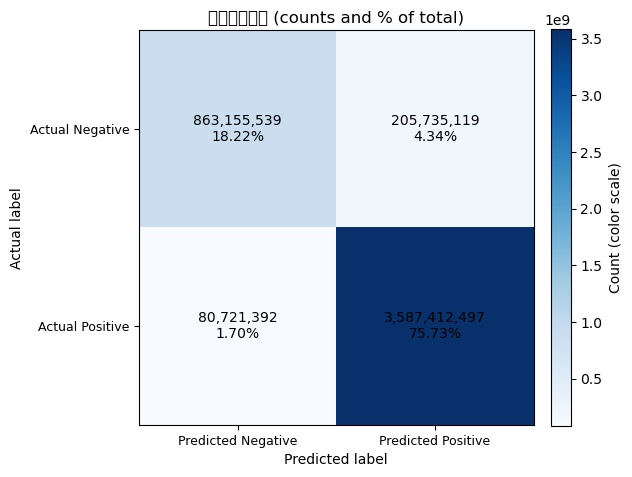

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 混淆矩阵元素（把 np.float64(...) 换成原始数值）
tn = 863155539.0
fp = 205735119.0
fn = 80721392.0
tp = 3587412497.0

cm = np.array([[tn, fp],
               [fn, tp]])
total = cm.sum()

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, cmap="Blues")

# 标注：显示计数（千位分隔）和占总体百分比
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = int(cm[i, j])
        pct = cm[i, j] / total * 100
        text = f"{count:,}\n{pct:.2f}%"
        ax.text(j, i, text, ha="center", va="center", color="black", fontsize=10)

# 标签与标题
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Predicted Negative", "Predicted Positive"], fontsize=9)
ax.set_yticklabels(["Actual Negative", "Actual Positive"], fontsize=9)
ax.set_xlabel("Predicted label")
ax.set_ylabel("Actual label")
ax.set_title("総体混淆矩阵 (counts and % of total)")

# 配色条、网格外观微调
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Count (color scale)")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# 总体混淆矩阵元素
tn = 863155539.0
fp = 205735119.0
fn = 80721392.0
tp = 3587412497.0

total = tn + fp + fn + tp
accuracy = (tp + tn) / total if total > 0 else np.nan
precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
recall = tp / (tp + fn) if (tp + fn) > 0 else np.nan
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) and not np.isnan(precision) and not np.isnan(recall) else np.nan

print(f"accuracy = {accuracy:.6f}")
print(f"precision = {precision:.6f}")
print(f"recall = {recall:.6f}")
print(f"f1 = {f1:.6f}")


accuracy = 0.939528
precision = 0.945761
recall = 0.977994
f1 = 0.961608


In [ ]:
TN=7483648036, FP=1822457885, FN=877111377, TP=32378023839
Precision=0.9467, Recall=0.9736, F1=0.9600


In [ ]:
Confusion counts -> TN:23009784622 FP:21251856403 FN:813153614 TP:32378265006
Metrics: {'overall': 0.7151176452146212, 'precision': 0.603732830643311, 'recall': 0.9755010889016349, 'f1': 0.7458578826218716}


In [ ]:
# Confusion counts -> TN:145486728 FP:36291177 FN:3086260 TP:48326097
# Define confusion matrix values
TN = 145486728
FP = 36291177
FN = 3086260
TP = 48326097

# Calculate accuracy
total = TN + FP + FN + TP
accuracy = (TN + TP) / total
print(f"Accuracy: {accuracy:.4f}")
recall = TP / (TP + FN)
print(f"Recall: {recall:.4f}")
# Calculate precision
precision = TP / (TP + FP)
print(f"Precision: {precision:.4f}")
# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score:.4f}")


Accuracy: 0.8311
Recall: 0.9400
Precision: 0.5711
F1 Score: 0.7105


In [1]:
import dask
from dask.distributed import Client, LocalCluster
dask.config.set({'scheduler': 'threads',
        'num_workers': 6,})


In [3]:
import rioxarray as rxr
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.pyplot as plt

path = "/projectnb/modislc/users/chishan/data/forest_comparison/encoded_cogs/glance_mapbiomas_encoded_2016.tif"

# colors = ["#2ca02c", "#d62728", "#ff7f0e", "#1f77b4"]  # TN/FP/FN/TP
# cmap = ListedColormap(colors, name="confusion4")
cmap = ListedColormap(["#2ca02c", "#d62728", "#ff7f0e", "#1f77b4"])
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

encoded_low = rxr.open_rasterio(
    path,
    masked=True,
    cache=False,
    transform=None,
    chunks=None,
    overview_level=2  # 传给底层 rasterio
).squeeze(drop=True)

encoded_low.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False)
plt.show()


MemoryError: Unable to allocate 38.6 GiB for an array with shape (30461, 42478, 4) and data type float64

<Figure size 640x480 with 1 Axes>

In [ ]:
# Confusion counts -> TN:145486728 FP:36291177 FN:3086260 TP:48326097
import rioxarray as rxr

path = "/projectnb/modislc/users/chishan/data/forest_comparison/encoded_cogs/glance_mapbiomas_encoded_2016.tif"
encoded = rxr.open_rasterio(path, chunks={"x": 2048, "y": 2048}).squeeze(drop=True)
print("values:", encoded.attrs.get("long_name", ""), encoded.dtype)


values:  uint8


In [ ]:
print(encoded.dims, encoded.coords)


('y', 'x') Coordinates:
  * x            (x) float64 3MB -73.98 -73.98 -73.98 ... -43.4 -43.4 -43.4
  * y            (y) float64 2MB 5.27 5.269 5.269 5.269 ... -16.66 -16.66 -16.66
    spatial_ref  int64 8B 0


In [ ]:
import hvplot.xarray  # noqa
from matplotlib.colors import ListedColormap

colors = ["#2ca02c", "#d62728", "#ff7f0e", "#1f77b4"]  # TN/FP/FN/TP
cmap = ListedColormap(colors, name="confusion4")

plot = encoded.hvplot.image(
    x="x",
    y="y",
    rasterize=True,          # 由 datashader 聚合，高效
    cmap=cmap,
    clim=(0, 3),             # 保证只用四个颜色
    colorbar=False,
    frame_width=600,
    tools=["hover"]
)
plot


KeyboardInterrupt: 

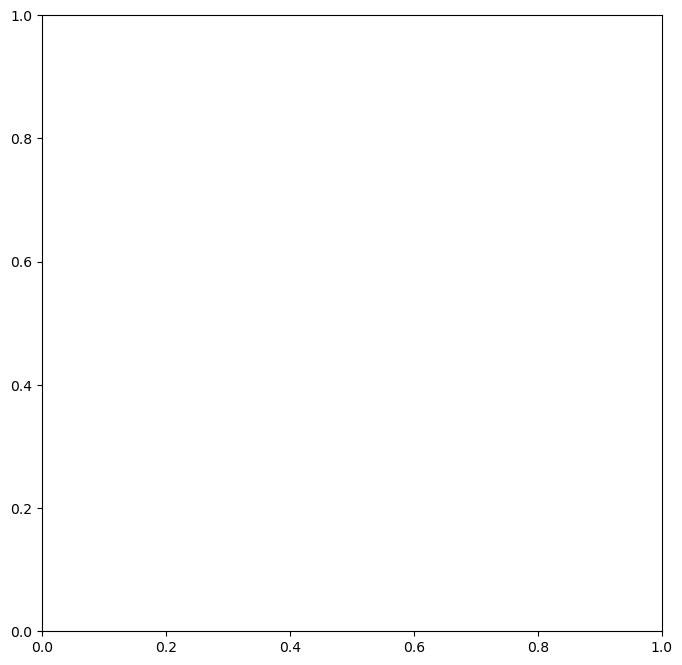

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap

cmap = ListedColormap(["#2ca02c", "#d62728", "#ff7f0e", "#1f77b4"])
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

fig, ax = plt.subplots(figsize=(8, 8))
encoded.plot.imshow(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
ax.set_title("GLANCE vs MapBiomas 2016 (TN/FP/FN/TP)")
# fig.savefig("glance_mapbiomas_2016_confusion.png", dpi=200, bbox_inches="tight")
plt.show()


In [ ]:
import os
import numpy as np
import xarray as xr
import dask
import dask.array as da
from odc.stac import load
import rioxarray
import pystac
import rasterio
from rasterio.windows import Window
from odc.geo.xr import write_cog  # 放在文件顶部 import 区

def load_glance_stac(stac_path, year, mapbiomas_geobox):
    """Load GLANCE tiles for a given year."""
    cat = pystac.Catalog.from_file(stac_path)

    def drop_tz(dt):
        return dt.replace(tzinfo=None) if dt.tzinfo else dt

    items = [
        i for i in cat.get_items(recursive=True)
        if i.datetime and year == drop_tz(i.datetime).year
    ]

    print(f"✓ {len(items)} GLANCE items found for {year}")
    ds = load(
        items,
        geobox=mapbiomas_geobox,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
    )
    return ds

year = 2016

# ---- 1. 配置单机调度器 ----
dask.config.set({
    'scheduler': 'threads',
    'num_workers': 8,
    'array.slicing.split_large_chunks': True,
})
print("✅ Dask threads scheduler enabled (28 threads)")

# ---- 2. Paths ----
stac_path = "/projectnb/modislc/users/chishan/stac_glance_SA/catalog.json"
mapbiomas_tif = f"/projectnb/modislc/users/chishan/data/MapBiomas/COG/AMZ.{year}.M.cog.tif"

# ---- 3. Load MapBiomas ----
mb = rioxarray.open_rasterio(mapbiomas_tif, chunks={"x": 2048, "y": 2048})
mb = mb.squeeze(drop=True)
mb_geobox = mb.odc.geobox
print(f"✓ MapBiomas loaded: shape={mb.shape}, dims={mb.dims}, CRS={mb.rio.crs}")

# ---- 4. Load GLANCE ----
ds = load_glance_stac(stac_path, year, mapbiomas_geobox=mb_geobox)
gl = ds["data"].isel(time=0)
print(f"✓ GLANCE loaded: shape={gl.shape}, dims={gl.dims}, CRS={gl.rio.crs}")


✅ Dask threads scheduler enabled (28 threads)
✓ MapBiomas loaded: shape=(243684, 339821), dims=('y', 'x'), CRS=EPSG:4674
✓ 1012 GLANCE items found for 2016
✓ GLANCE loaded: shape=(243684, 339821), dims=('latitude', 'longitude'), CRS=EPSG:4674


In [4]:
print("MapBiomas nodata:", mb.rio.nodata)


NameError: name 'mb' is not defined

In [12]:
gl.data.map_blocks(lambda blk: np.mean(~np.isnan(blk)))


dask.array<lambda, shape=(243684, 339821), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>

In [7]:
len(ds)


1

In [ ]:
gl.notnull().mean()


<xarray.DataArray 'data' ()> Size: 8B
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 4B 4674
    time         datetime64[ns] 8B 2016-07-01

In [15]:
def load_glance_stac_search(stac_path, year, mapbiomas_geobox):
    """使用 PySTAC 的搜索功能进行空间和时间筛选"""
    cat = pystac.Catalog.from_file(stac_path)
    
    # 获取 bbox
    mb_bounds = mapbiomas_geobox.boundingbox
    bbox = [mb_bounds.left, mb_bounds.bottom, mb_bounds.right, mb_bounds.top]
    
    # 时间范围
    datetime_range = f"{year}-01-01/{year}-12-31"
    
    print(f"🔍 Searching STAC catalog:")
    print(f"   bbox: {bbox}")
    print(f"   datetime: {datetime_range}")
    
    # 使用 PySTAC 的搜索（如果 catalog 支持）
    try:
        # 注意：不是所有 catalog 都支持 .search()
        search = cat.search(
            bbox=bbox,
            datetime=datetime_range
        )
        items = list(search.items())
    except AttributeError:
        # 如果不支持 search，手动筛选
        print("⚠️  Catalog doesn't support search, filtering manually...")
        
        def drop_tz(dt):
            return dt.replace(tzinfo=None) if dt.tzinfo else dt
        
        all_items = list(cat.get_items(recursive=True))
        
        def bbox_intersects(item_bbox, search_bbox):
            return not (
                item_bbox[2] < search_bbox[0] or
                item_bbox[0] > search_bbox[2] or
                item_bbox[3] < search_bbox[1] or
                item_bbox[1] > search_bbox[3]
            )
        
        items = [
            i for i in all_items
            if i.datetime 
            and year == drop_tz(i.datetime).year
            and bbox_intersects(i.bbox, bbox)
        ]
    
    print(f"✓ {len(items)} GLANCE items found")
    
    if len(items) == 0:
        raise ValueError("No items found matching criteria!")
    
    # 打印找到的 items
    for item in items:
        print(f"  - {item.id}: {item.datetime}")
    
    # 加载数据
    ds = load(
        items,
        geobox=mapbiomas_geobox,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
    )
    
    print(f"✓ Dataset loaded: shape={ds['data'].shape}, dims={ds['data'].dims}")
    
    return ds

# 在 main() 函数中
ds = load_glance_stac_search(stac_path, year, mapbiomas_geobox=mb_geobox)
gl = ds["data"].isel(time=0)


🔍 Searching STAC catalog:
   bbox: [-73.98318216, -16.661979170000002, -43.39929216, 5.26958083]
   datetime: 2016-01-01/2016-12-31
⚠️  Catalog doesn't support search, filtering manually...
✓ 1 GLANCE items found
  - glance_2016_h46v32: 2016-07-01 00:00:00+00:00
✓ Dataset loaded: shape=(1, 243684, 339821), dims=('time', 'latitude', 'longitude')


In [24]:
import pystac

stac_path = "/projectnb/modislc/users/chishan/stac_glance_SA_fixed_m/catalog.json"

cat = pystac.Catalog.from_file(stac_path)
items = list(cat.get_items(recursive=True))
print(f"Total items: {len(items)}")

# 检查第一个 item 的投影信息
item = items[0]
print(f"\nItem: {item.id}")
print(f"  EPSG: {item.properties.get('proj:epsg')}")
print(f"  Transform: {item.properties.get('proj:transform')}")
print(f"  Shape: {item.properties.get('proj:shape')}")
print(f"  Original bbox: {item.properties.get('proj:bbox')}")
print(f"  WGS84 bbox: {item.bbox}")


Total items: 19228

Item: glance_2001_h17v44
  EPSG: 10603
  Transform: [30.0, 0.0, -4368770.0, 0.0, -30.0, -1700295.0]
  Shape: [5000, 5000]
  Original bbox: [-4368770.0, -1850295.0, -4218770.0, -1700295.0]
  WGS84 bbox: [-105.30316572361248, -27.000763322078498, -103.28998070497362, -25.44816054627963]


In [25]:
def load_glance_stac_search(stac_path, year, mapbiomas_geobox):
    """使用 PySTAC 的搜索功能进行空间和时间筛选"""
    cat = pystac.Catalog.from_file(stac_path)
    
    # 获取 bbox
    mb_bounds = mapbiomas_geobox.boundingbox
    bbox = [mb_bounds.left, mb_bounds.bottom, mb_bounds.right, mb_bounds.top]
    
    # 时间范围
    datetime_range = f"{year}-01-01/{year}-12-31"
    
    print(f"🔍 Searching STAC catalog:")
    print(f"   bbox: {bbox}")
    print(f"   datetime: {datetime_range}")
    
    # 使用 PySTAC 的搜索（如果 catalog 支持）
    try:
        # 注意：不是所有 catalog 都支持 .search()
        search = cat.search(
            bbox=bbox,
            datetime=datetime_range
        )
        items = list(search.items())
    except AttributeError:
        # 如果不支持 search，手动筛选
        print("⚠️  Catalog doesn't support search, filtering manually...")
        
        def drop_tz(dt):
            return dt.replace(tzinfo=None) if dt.tzinfo else dt
        
        all_items = list(cat.get_items(recursive=True))
        
        def bbox_intersects(item_bbox, search_bbox):
            return not (
                item_bbox[2] < search_bbox[0] or
                item_bbox[0] > search_bbox[2] or
                item_bbox[3] < search_bbox[1] or
                item_bbox[1] > search_bbox[3]
            )
        
        items = [
            i for i in all_items
            if i.datetime 
            and year == drop_tz(i.datetime).year
            and bbox_intersects(i.bbox, bbox)
        ]
    
    print(f"✓ {len(items)} GLANCE items found")
    
    if len(items) == 0:
        raise ValueError("No items found matching criteria!")
    
    # 打印找到的 items
    for item in items:
        print(f"  - {item.id}: {item.datetime}")
    
    # 加载数据
    ds = load(
        items,
        geobox=mapbiomas_geobox,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
    )
    
    print(f"✓ Dataset loaded: shape={ds['data'].shape}, dims={ds['data'].dims}")
    
    return ds

# 在 main() 函数中
ds = load_glance_stac_search(stac_path, year, mapbiomas_geobox=mb_geobox)
gl = ds["data"].isel(time=0)


🔍 Searching STAC catalog:
   bbox: [-73.98318216, -16.661979170000002, -43.39929216, 5.26958083]
   datetime: 2016-01-01/2016-12-31
⚠️  Catalog doesn't support search, filtering manually...
✓ 388 GLANCE items found
  - glance_2016_h35v19: 2016-07-01 00:00:00+00:00
  - glance_2016_h35v18: 2016-07-01 00:00:00+00:00
  - glance_2016_h35v20: 2016-07-01 00:00:00+00:00
  - glance_2016_h35v22: 2016-07-01 00:00:00+00:00
  - glance_2016_h35v21: 2016-07-01 00:00:00+00:00
  - glance_2016_h35v23: 2016-07-01 00:00:00+00:00
  - glance_2016_h35v24: 2016-07-01 00:00:00+00:00
  - glance_2016_h35v26: 2016-07-01 00:00:00+00:00
  - glance_2016_h35v25: 2016-07-01 00:00:00+00:00
  - glance_2016_h35v27: 2016-07-01 00:00:00+00:00
  - glance_2016_h35v28: 2016-07-01 00:00:00+00:00
  - glance_2016_h35v30: 2016-07-01 00:00:00+00:00
  - glance_2016_h35v29: 2016-07-01 00:00:00+00:00
  - glance_2016_h36v17: 2016-07-01 00:00:00+00:00
  - glance_2016_h36v18: 2016-07-01 00:00:00+00:00
  - glance_2016_h36v20: 2016-07-01 

In [26]:
gl.notnull().mean().compute().item()


0.935322527742513

In [ ]:
# 只显示第一个 time 并限制输出像素总数（更安全）
m = gl.odc.explore(max_size=512)  # max_size 控制最长边像素数


: 

: 

: 

In [ ]:
# 将 start_time 和 end_time 替换为 ISO 时间或 epoch 秒，示例返回每-chunk 平均与剩余时间估计
start_time = "2025-10-19T08:00:00"  # 示例
end_time = "2025-10-19T09:30:00"    # 示例
from datetime import datetime
st = datetime.fromisoformat(start_time)
et = datetime.fromisoformat(end_time)
elapsed = (et - st).total_seconds()
processed_chunks = 24
avg_sec_per_chunk = elapsed / processed_chunks
remaining_chunks = 1260 - processed_chunks
remaining_seconds = remaining_chunks * avg_sec_per_chunk
print("avg_sec_per_chunk=", avg_sec_per_chunk, "remaining_seconds=", remaining_seconds, "=> hours=", remaining_seconds/3600)


avg_sec_per_chunk= 225.0 remaining_seconds= 278100.0 => hours= 77.25


In [ ]:
print(16*16)


256


In [6]:
cat = pystac.Catalog.from_file(stac_path)

time_range = "2016-01-01/2016-12-31"
# bbox = [-122.2751, 47.5469, -121.9613, 47.7458]

search = cat.search(bbox=mb_geobox, datetime=time_range)
items = search.get_all_items()
len(items)


AttributeError: 'Catalog' object has no attribute 'search'

In [19]:
import pystac

catalog = pystac.Catalog.from_file(stac_path)

# 搜索 2016 年的所有 Item
matches = list(catalog.search(
    collections=["glance_collection"],  # 可选；不写则遍历所有 Collection
    datetime="2016-01-01/2016-12-31"
))

print(len(matches))
for item in matches[:5]:
    print(item.id, item.datetime)

# 按 bounding box 搜索
matches_bbox = list(catalog.search(
    bbox=[-72, -10, -70, -8]
))


AttributeError: 'Catalog' object has no attribute 'search'

In [ ]:
import pystac
from pystac.item_search import ItemSearch
cat = pystac.Catalog.from_file(stac_path)
search = ItemSearch(cat, collections=["glance_collection"], datetime="2016-01-01/2016-12-31", bbox=[-72, -10, -70, -8])
items = list(search.items())


ModuleNotFoundError: No module named 'pystac.item_search'

In [22]:
import pystac

catalog = pystac.Catalog.from_file(stac_path)

search = pystac.ItemSearch(
    catalog,
    collections=["glance_collection"],        # optional
    datetime="2016-01-01/2016-12-31",
    bbox=[-72, -10, -70, -8],                 # optional
)
items = list(search.items())


AttributeError: module 'pystac' has no attribute 'ItemSearch'

In [ ]:
print(pystac.__version__)


1.14.1


In [2]:
# 这将使用 folium 在交互式地图上绘制 gl 数据的分布
# 您可能需要在 Jupyter 环境（如 Notebook 或 Lab）中运行它才能看到输出
m = gl.odc.explore()

# 您也可以将 MapBiomas 数据添加到同一张地图上
# mb.odc.explore(map=m, cmap="viridis")


MemoryError: Unable to allocate 109. GiB for an array with shape (169984, 171885) and data type float32

In [ ]:
# 这将只在地图上绘制 gl 数据的 *范围*（边界框）
m = gl.odc.geobox.explore()

# 您也可以将 MapBiomas 数据的范围添加到同一张地图上
# mb.odc.geobox.explore(map=m, style_kwds={"color": "red"})


In [5]:
ds["data"]


<xarray.DataArray 'data' (time: 1, latitude: 243684, longitude: 339821)> Size: 331GB
dask.array<data, shape=(1, 243684, 339821), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 2MB 5.27 5.269 5.269 ... -16.66 -16.66
  * longitude    (longitude) float64 3MB -73.98 -73.98 -73.98 ... -43.4 -43.4
    spatial_ref  int32 4B 4674
  * time         (time) datetime64[ns] 8B 2016-07-01

In [ ]:
print(ds.time.dt.floor("D").values)


['2016-07-01T00:00:00.000000000']


In [3]:
gl


<xarray.DataArray 'data' (latitude: 243684, longitude: 339821)> Size: 331GB
dask.array<getitem, shape=(243684, 339821), dtype=float32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 2MB 5.27 5.269 5.269 ... -16.66 -16.66
  * longitude    (longitude) float64 3MB -73.98 -73.98 -73.98 ... -43.4 -43.4
    spatial_ref  int32 4B 4674
    time         datetime64[ns] 8B 2016-07-01

In [8]:
sub = gl.isel({gl.rio.y_dim: slice(0, 2048),
                    gl.rio.x_dim: slice(0, 2048)}).compute().values
print("unique(sub)[:10] =", np.unique(sub)[:10])


unique(sub)[:10] = [nan]


In [ ]:
gl_stack = ds["data"].where(ds["data"] != ds["data"].rio.nodata)
gl = gl_stack.max(dim="time")
# 或 gl = gl_stack.median(dim="time") / gl = gl_stack.any(dim="time")


In [ ]:
def load_glance_stac(stac_path, year, mapbiomas_geobox):
    """Load GLANCE tiles for a given year."""
    cat = pystac.Catalog.from_file(stac_path)

    def drop_tz(dt):
        return dt.replace(tzinfo=None) if dt.tzinfo else dt

    items = [
        i for i in cat.get_items(recursive=True)
        if i.datetime and year == drop_tz(i.datetime).year
    ]
    

    print(f"✓ {len(items)} GLANCE items found for {year}")
    
    # 先加载原始数据，不指定 geobox
    ds_raw = load(
        items,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
    )
    
    print(f"✓ GLANCE raw loaded: shape={ds_raw['data'].shape}, dims={ds_raw['data'].dims}")
    print(f"✓ GLANCE CRS: {ds_raw['data'].rio.crs}")
    print(f"✓ GLANCE bounds: {ds_raw['data'].rio.bounds()}")
    
    # 重投影到 MapBiomas 的 CRS 和范围
    ds_reproj = ds_raw.odc.reproject(
        mapbiomas_geobox,
        resampling="nearest",
        chunks={"x": 2048, "y": 2048}
    )
    
    print(f"✓ GLANCE reprojected: shape={ds_reproj['data'].shape}, dims={ds_reproj['data'].dims}")
    print(f"✓ GLANCE reprojected bounds: {ds_reproj['data'].rio.bounds()}")
    
    return ds_reproj

ds_reproj = load_glance_stac(
    stac_path,
    year,
    mapbiomas_geobox=mb_geobox
)


✓ 1012 GLANCE items found for 2016


ValueError: Failed to auto-guess CRS/resolution.

In [ ]:
def main():
    year = 2016

    # ---- 1. 配置单机调度器 ----
    dask.config.set({
        'scheduler': 'threads',
        'num_workers': 28,
        'array.slicing.split_large_chunks': True,
    })
    print("✅ Dask threads scheduler enabled (28 threads)")

    # ---- 2. Paths ----
    stac_path = "/projectnb/modislc/users/chishan/stac_glance_SA/catalog.json"
    mapbiomas_tif = f"/projectnb/modislc/users/chishan/data/MapBiomas/COG/AMZ.{year}.M.cog.tif"

    # ---- 3. Load MapBiomas ----
    mb = rioxarray.open_rasterio(mapbiomas_tif, chunks={"x": 2048, "y": 2048})
    mb = mb.squeeze(drop=True)
    mb_geobox = mb.odc.geobox
    print(f"✓ MapBiomas loaded: shape={mb.shape}, dims={mb.dims}, CRS={mb.rio.crs}")
    print(f"✓ MapBiomas bounds: {mb.rio.bounds()}")

    # ---- 4. Load GLANCE (先不重投影，检查原始数据) ----
    cat = pystac.Catalog.from_file(stac_path)
    def drop_tz(dt):
        return dt.replace(tzinfo=None) if dt.tzinfo else dt
    
    items = [
        i for i in cat.get_items(recursive=True)
        if i.datetime and year == drop_tz(i.datetime).year
    ]
    
    print(f"✓ {len(items)} GLANCE items found for {year}")
    
    # 先加载原始数据看看
    ds_raw = load(items, chunks={"x": 2048, "y": 2048}, groupby="solar_day")
    gl_raw = ds_raw["data"].isel(time=0)
    
    print(f"✓ GLANCE raw: shape={gl_raw.shape}, dims={gl_raw.dims}, CRS={gl_raw.rio.crs}")
    print(f"✓ GLANCE raw bounds: {gl_raw.rio.bounds()}")
    print(f"✓ GLANCE unique values (sample): {np.unique(gl_raw.isel(y=slice(0,100), x=slice(0,100)).compute())[:20]}")
    
    # 检查边界是否有交集
    mb_bounds = mb.rio.bounds()
    gl_bounds = gl_raw.rio.bounds()
    
    print("\n=== Checking spatial overlap ===")
    print(f"MapBiomas: ({mb_bounds[0]:.2f}, {mb_bounds[1]:.2f}) to ({mb_bounds[2]:.2f}, {mb_bounds[3]:.2f})")
    print(f"GLANCE:    ({gl_bounds[0]:.2f}, {gl_bounds[1]:.2f}) to ({gl_bounds[2]:.2f}, {gl_bounds[3]:.2f})")
    
    # 计算交集
    overlap_xmin = max(mb_bounds[0], gl_bounds[0])
    overlap_ymin = max(mb_bounds[1], gl_bounds[1])
    overlap_xmax = min(mb_bounds[2], gl_bounds[2])
    overlap_ymax = min(mb_bounds[3], gl_bounds[3])
    
    if overlap_xmin < overlap_xmax and overlap_ymin < overlap_ymax:
        print(f"✓ Overlap exists: ({overlap_xmin:.2f}, {overlap_ymin:.2f}) to ({overlap_xmax:.2f}, {overlap_ymax:.2f})")
    else:
        print("❌ NO OVERLAP! The datasets don't intersect spatially!")
        return
    
    # 现在重投影
    print("\n⏳ Reprojecting GLANCE to MapBiomas geobox...")
    gl = gl_raw.odc.reproject(mb_geobox, resampling="nearest")
    
    print(f"✓ GLANCE reprojected: shape={gl.shape}, dims={gl.dims}")
    print(f"✓ GLANCE unique values (after reproject, sample): {np.unique(gl.isel(y=slice(0,100), x=slice(0,100)).compute())[:20]}")

    # # ---- 5. Reclassify ----
    # mb_bin = reclassify_to_forest(mb, [1, 2, 9])
    # gl_bin = reclassify_to_forest(gl, [5])
    
    # ...existing code...


In [ ]:
import contextily

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=[-124.2751, 45.5469, -110.9613, 47.7458],
    datetime="2020-12-26/2020-12-31",
)
items = search.item_collection()

df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")

ax = df[["geometry", "datetime", "s2:mgrs_tile", "eo:cloud_cover"]].plot(
    facecolor="none", figsize=(12, 6)
)
contextily.add_basemap(
    ax, crs=df.crs.to_string(), source=contextily.providers.Esri.NatGeoWorldMap
);


In [ ]:
import os
import numpy as np
import xarray as xr
import dask
import dask.array as da
from odc.stac import load
import rioxarray
import pystac
import rasterio
from rasterio.windows import Window
from odc.geo.xr import write_cog  # 放在文件顶部 import 区

dask.config.set({'scheduler': 'threads',
        'num_workers': 8,})


In [8]:
year = 2016
mapbiomas_tif = f"/projectnb/modislc/users/chishan/data/MapBiomas/COG/AMZ.{year}.M.cog.tif"

# ---- 3. Load MapBiomas ----
mb = rioxarray.open_rasterio(mapbiomas_tif, chunks={"x": 2048, "y": 2048})
mb = mb.squeeze(drop=True)
mb_geobox = mb.odc.geobox
print(f"✓ MapBiomas loaded: shape={mb.shape}, dims={mb.dims}, CRS={mb.rio.crs}")


✓ MapBiomas loaded: shape=(243684, 339821), dims=('y', 'x'), CRS=EPSG:4674


In [ ]:
print('MapBiomas nodata:', mb.rio.nodata)


MapBiomas nodata: 0
